In [9]:

from alpaca.trading.requests import GetOrdersRequest
from alpaca.trading.enums import OrderStatus
from alpaca.trading.client import TradingClient

trading_client = TradingClient(APCA_API_KEY_ID, APCA_API_SECRET_KEY, paper=True)

request = GetOrdersRequest(status="all")
orders = trading_client.get_orders(filter=request)

orders

[{   'asset_class': <AssetClass.US_EQUITY: 'us_equity'>,
     'asset_id': UUID('b0b6dd9d-8b9b-48a9-ba46-b9d54906e415'),
     'canceled_at': None,
     'client_order_id': '775abafd-c845-4b2c-8864-da81f1b147ff',
     'created_at': datetime.datetime(2025, 7, 25, 1, 8, 51, 588863, tzinfo=TzInfo(UTC)),
     'expired_at': None,
     'expires_at': datetime.datetime(2025, 10, 23, 20, 0, tzinfo=TzInfo(UTC)),
     'extended_hours': False,
     'failed_at': None,
     'filled_at': datetime.datetime(2025, 7, 25, 13, 30, 38, 582174, tzinfo=TzInfo(UTC)),
     'filled_avg_price': '214.4',
     'filled_qty': '1',
     'hwm': None,
     'id': UUID('26a553c3-7f5c-4240-b2c7-0089e95fc4cf'),
     'legs': None,
     'limit_price': None,
     'notional': None,
     'order_class': <OrderClass.SIMPLE: 'simple'>,
     'order_type': <OrderType.MARKET: 'market'>,
     'position_intent': <PositionIntent.BUY_TO_OPEN: 'buy_to_open'>,
     'qty': '1',
     'ratio_qty': None,
     'replaced_at': None,
     'replaced_b

In [8]:
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from ta.momentum import RSIIndicator
from ta.trend import ADXIndicator
from sklearn.linear_model import LinearRegression


from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest


from alpaca_secrets import APCA_API_KEY_ID, APCA_API_SECRET_KEY
import pandas as pd
import numpy as np
import talib

from backtesting import Strategy
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from datetime import datetime, timedelta
import inspect


trading_client = TradingClient(APCA_API_KEY_ID, APCA_API_SECRET_KEY)

import multiprocessing as mp

mp.set_start_method("fork", force=True)


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

# Data Collection

In [17]:
# search for US equities
search_params = GetAssetsRequest(asset_class=AssetClass.US_EQUITY)

assets = trading_client.get_all_assets(search_params)

In [18]:
def  prepare_data(list_symbol, n_years = 5):

    data_client = StockHistoricalDataClient(APCA_API_KEY_ID, APCA_API_SECRET_KEY)

    end_date = datetime(2025,7,15)
    start_date = end_date - timedelta(days=n_years*365)

    # Solicite os dados OHLC para os símbolos desejados
    bars_request = StockBarsRequest(
        symbol_or_symbols=list_symbol,
        timeframe=TimeFrame.Minute,
        # timeframe=TimeFrame.Hour,
        start=start_date,
        end=end_date,
        adjustment="all"

    )

    bars = data_client.get_stock_bars(bars_request).data

    dfs = {}
    for sym in list_symbol:
        print(f"Processing {sym}")

        try:
            asset = trading_client.get_asset(sym)
            print(f"{asset.symbol}: Tradable = {asset.tradable}")
        except Exception as e:
            print(f"{sym}: Error - {e}")


        candle = bars.get(sym, None)
        if candle is not None:
            dfs[sym] = pd.DataFrame([{k: getattr(bar, k) for k in ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap']} for bar in candle])
        
        
            # Supondo que df tenha ['open', 'high', 'low', 'close', 'volume']
            df = dfs[sym][['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
            df.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df.set_index('Timestamp', inplace=True)
            dfs[sym] = df
        
    return dfs


In [19]:
def prepare_crypto_data(list_symbol, n_years=1):
    client = CryptoHistoricalDataClient(APCA_API_KEY_ID, APCA_API_SECRET_KEY)
    end = datetime(2025, 7, 15)
    start = end - timedelta(days=n_years*365)

    crypto_data = {}

    for symbol in list_symbol:
        print(f"Fetching {symbol}...")

        request = CryptoBarsRequest(
            symbol_or_symbols=symbol,
            start=start,
            end=end,
            timeframe=TimeFrame.Minute,
            # timeframe=TimeFrame.Hour,
            adjustment="all"
        )

        bars = client.get_crypto_bars(request).df
        if bars.empty:
            print(f"No data for {symbol}")
            continue

        df = bars[bars.index.get_level_values(0) == symbol].droplevel(0).copy()
        df.index.name = "timestamp"
        df = df.rename(columns=str.lower)
        df = df.reset_index()

        # Supondo que df tenha ['open', 'high', 'low', 'close', 'volume']
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
        df.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)

        crypto_data[symbol] = df

    return crypto_data


In [20]:
def printa_resultados(results):
    print(f"Return [%]:           {results['Return [%]']:.2f}")
    print(f"Buy & Hold Return [%]: {results['Buy & Hold Return [%]']:.2f}")
    print(f"Sharpe Ratio:         {results['Sharpe Ratio']:.2f}")
    print(f"# Trades:             {results['_trades'].shape[0]}")
    print(f"Win Rate:             {results['Win Rate [%]']:.2f}%")
    print(f"Max Drawdown [%]:     {results['Max. Drawdown [%]']:.2f}")
    print(f"Avg Trade Duration:   {results['Avg. Trade Duration']}")
    print(f"Best Trade [%]:       {results['Best Trade [%]']:.2f}")
    print(f"Worst Trade [%]:      {results['Worst Trade [%]']:.2f}")
    print("="*60)

## ETFs Data

•	ETFs de renda fixa (ex: TLT, HYG) e ouro (GLD, IAU) costumam ter movimentos mais suaves, o que pode ajudar a estratégia.


In [3]:
list_symbol_ = ["SPY","QQQ","IWM","DIA","XLF","XLK","GLD","IAU","TLT","HYG",]

etfs_close_data={}

for sym in list_symbol_:
    etfs_close_data[sym] = pd.read_csv(
        f"etfs_{sym.split()[0]}.csv", index_col=0, parse_dates=True)

# etfs_close_data = prepare_data(list_symbol_, n_years = 1)

etfs_close_data.keys()

dict_keys(['SPY', 'QQQ', 'IWM', 'DIA', 'XLF', 'XLK', 'GLD', 'IAU', 'TLT', 'HYG'])

## Equities Data

•	Ações com volatilidade moderada (ex: MSFT, JPM) também funcionam bem para testes de reversão à média.


In [6]:
eqt_symbol_ = ["AAPL","MSFT","GOOG","META","TSLA"]#,"NVDA","JP",]

eqt_close_data={}

for sym in eqt_symbol_:
    eqt_close_data[sym] = pd.read_csv(
        f"eqt_{sym.split()[0]}.csv", index_col=0, parse_dates=True)

# eqt_close_data = prepare_data(list_symbol_, n_years = 1)

eqt_close_data.keys()

dict_keys(['AAPL', 'MSFT', 'GOOG', 'META', 'TSLA'])

## Crypto Data


In [7]:
crypto_symbols = ["BTC/USD", "ETH/USD", "SOL/USD", "XRP/USD"]

crypto_close_data={}

for sym in crypto_symbols:
    crypto_close_data[sym] = pd.read_csv(
        f"crypto_{sym.split('/')[0]}.csv", index_col=0, parse_dates=True)

# crypto_close_data = prepare_crypto_data(crypto_symbols, n_years=1)

crypto_close_data.keys()  # dict com os DataFrames
crypto_close_data["BTC/USD"].head()

Open        High         Low       Close  \
Timestamp                                                                   
2024-07-15 00:00:00+00:00  60856.4680  60856.4680  60820.9735  60820.9735   
2024-07-15 00:02:00+00:00  60854.2450  60854.2450  60854.2450  60854.2450   
2024-07-15 00:03:00+00:00  60868.9000  60868.9000  60868.9000  60868.9000   
2024-07-15 00:05:00+00:00  60844.4855  60844.4855  60844.4855  60844.4855   
2024-07-15 00:08:00+00:00  60809.6100  60809.6100  60776.0935  60776.0935   

                           Volume  
Timestamp                          
2024-07-15 00:00:00+00:00     0.0  
2024-07-15 00:02:00+00:00     0.0  
2024-07-15 00:03:00+00:00     0.0  
2024-07-15 00:05:00+00:00     0.0  
2024-07-15 00:08:00+00:00     0.0

# Trend strats

## MACrossover

In [44]:
class MACrossover(Strategy):
    short_window = 5
    long_window = 60
    buffer_pct = 0.00  # 0.1%

    def init(self):
        close = self.data.Close
        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_long) < 2:
            return

        price = self.data.Close[-1]
        diff = self.ma_short[-1] - self.ma_long[-1]

        # Aplica o buffer
        if diff > self.buffer_pct * price and self.ma_short[-2] <= self.ma_long[-2]:
            if self.position.is_short:
                self.position.close()
            if not self.position.is_long:
                self.buy(size=10)

        elif diff < -self.buffer_pct * price and self.ma_short[-2] >= self.ma_long[-2]:
            if self.position.is_long:
                self.position.close()
            if not self.position.is_short:
                self.sell(size=10)

In [30]:
class MACrossoverADX(Strategy):
    short_window = 23
    long_window = 40
    adx_threshold = 35
    T_period = 14

    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

        self.adx = self.I(lambda h, l, c: talib.ADX(h, l, c, timeperiod=self.T_period),
                          self.data.High, self.data.Low, self.data.Close,
                          name='adx')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_long) < 2 or len(self.adx) < 2:
            return

        price = self.data.Close[-1]
        adx = self.adx[-1]

        # Só entra se ADX estiver acima do limite mínimo
        if adx < self.adx_threshold:
            return

        # Lógica de cruzamento das médias
        cross_up = self.ma_short[-1] > self.ma_long[-1] and self.ma_short[-2] <= self.ma_long[-2]
        cross_down = self.ma_short[-1] < self.ma_long[-1] and self.ma_short[-2] >= self.ma_long[-2]

        if cross_up:
            if self.position.is_short:
                self.position.close()
            if not self.position.is_long:
                self.buy(size=10)

        elif cross_down:
            if self.position.is_long:
                self.position.close()
            if not self.position.is_short:
                self.sell(size=10)

In [10]:
class MACrossoverADXStopLoss(Strategy):
    short_window = 10
    long_window = 70
    adx_threshold = 30
    T_period = 14
    stop_loss_pct = 0.05 # 1%


    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

        self.adx = self.I(lambda h, l, c: talib.ADX(h, l, c, timeperiod=self.T_period),
                          self.data.High, self.data.Low, self.data.Close,
                          name='adx')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_long) < 2 or len(self.adx) < 2:
            return

        price = self.data.Close[-1]
        adx = self.adx[-1]

        # Stop loss dinâmico
        if self.position and self.trades:
            entry_price = self.trades[-1].entry_price

            if self.position.is_long:
                loss = (price - entry_price) / entry_price
                if loss < -self.stop_loss_pct:
                    self.position.close()
                    return

            elif self.position.is_short:
                loss = (entry_price - price) / entry_price
                if loss < -self.stop_loss_pct:
                    self.position.close()
                    return

        if adx < self.adx_threshold:
            return

        cross_up = self.ma_short[-1] > self.ma_long[-1] and self.ma_short[-2] <= self.ma_long[-2]
        cross_down = self.ma_short[-1] < self.ma_long[-1] and self.ma_short[-2] >= self.ma_long[-2]

        if cross_up:
            if self.position.is_short:
                self.position.close()
            if not self.position.is_long:
                self.buy(size=10)

        elif cross_down:
            if self.position.is_long:
                self.position.close()
            if not self.position.is_short:
                self.sell(size=10)

In [ ]:
class MACrossoverADXBufferedStopLoss(Strategy):
    short_window = 20
    long_window = 50
    adx_threshold = 20
    buffer_pct = 0.001  # 1% do preço atual
    T_period = 14
    stop_loss_pct = 0.01

    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

        self.adx = self.I(lambda h, l, c: talib.ADX(h, l, c, timeperiod=self.T_period),
                          self.data.High, self.data.Low, self.data.Close,
                          name='adx')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_long) < 2 or len(self.adx) < 2:
            return

        price = self.data.Close[-1]
        adx = self.adx[-1]
        diff = self.ma_short[-1] - self.ma_long[-1]
        buffer = self.buffer_pct * price

        # Stop loss dinâmico
        if self.position and self.trades:
            entry_price = self.trades[-1].entry_price

            if self.position.is_long:
                loss = (price - entry_price) / entry_price
                if loss < -self.stop_loss_pct:
                    self.position.close()
                    return

            elif self.position.is_short:
                loss = (entry_price - price) / entry_price
                if loss < -self.stop_loss_pct:
                    self.position.close()
                    return

        cross_up = diff > buffer and self.ma_short[-2] <= self.ma_long[-2]
        cross_down = diff < -buffer and self.ma_short[-2] >= self.ma_long[-2]

        # ENTRY: cruzamento com ADX forte e diferença significativa
        if not self.position:
            if cross_up and adx > self.adx_threshold:
                self.buy(size=10)
            elif cross_down and adx > self.adx_threshold:
                self.sell(size=10)

        # EXIT: tendência perdeu força ou cruzamento oposto com margem suficiente
        else:
            # exit_due_to_adx = adx < self.adx_threshold
            reverse_cross_up = diff > buffer and self.ma_short[-2] <= self.ma_long[-2]
            reverse_cross_down = diff < -buffer and self.ma_short[-2] >= self.ma_long[-2]

            # if self.position.is_long and (exit_due_to_adx or reverse_cross_down):
            if self.position.is_long and (reverse_cross_down):
                self.position.close()

            # elif self.position.is_short and (exit_due_to_adx or reverse_cross_up):
            elif self.position.is_short and (reverse_cross_up):
                self.position.close()

In [10]:
class MACrossoverADXTrendAware(Strategy):
    short_window = 20
    long_window = 50
    adx_threshold = 20
    T_period = short_window


    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

        self.adx = self.I(lambda h, l, c: talib.ADX(h, l, c, timeperiod=self.T_period),
                          self.data.High, self.data.Low, self.data.Close,
                          name='adx')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_long) < 2 or len(self.adx) < 2:
            return

        price = self.data.Close[-1]
        adx = self.adx[-1]

        cross_up = self.ma_short[-1] > self.ma_long[-1] and self.ma_short[-2] <= self.ma_long[-2]
        cross_down = self.ma_short[-1] < self.ma_long[-1] and self.ma_short[-2] >= self.ma_long[-2]

        # ENTRY: cruzamento com tendência forte
        if not self.position:
            if cross_up and adx > self.adx_threshold:
                self.buy(size=10)
            elif cross_down and adx > self.adx_threshold:
                self.sell(size=10)

        # EXIT: tendência perdeu força ou cruzamento contrário
        else:
            exit_condition = adx < self.adx_threshold

            if self.position.is_long:
                if exit_condition or cross_down:
                    self.position.close()

            elif self.position.is_short:
                if exit_condition or cross_up:
                    self.position.close()

In [11]:
class MACrossoverADXBuffered(Strategy):
    short_window = 20
    long_window = 50
    adx_threshold = 20
    buffer_pct = 0.001  # 1% do preço atual

    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

        self.adx = self.I(lambda h, l, c: talib.ADX(h, l, c, timeperiod=14),
                          self.data.High, self.data.Low, self.data.Close,
                          name='adx')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_long) < 2 or len(self.adx) < 2:
            return

        price = self.data.Close[-1]
        adx = self.adx[-1]
        diff = self.ma_short[-1] - self.ma_long[-1]
        buffer = self.buffer_pct * price

        cross_up = diff > buffer and self.ma_short[-2] <= self.ma_long[-2]
        cross_down = diff < -buffer and self.ma_short[-2] >= self.ma_long[-2]

        # ENTRY: cruzamento com ADX forte e diferença significativa
        if not self.position:
            if cross_up and adx > self.adx_threshold:
                self.buy(size=10)
            elif cross_down and adx > self.adx_threshold:
                self.sell(size=10)

        # EXIT: tendência perdeu força ou cruzamento oposto com margem suficiente
        else:
            exit_due_to_adx = adx < self.adx_threshold
            reverse_cross_up = diff > buffer and self.ma_short[-2] <= self.ma_long[-2]
            reverse_cross_down = diff < -buffer and self.ma_short[-2] >= self.ma_long[-2]

            if self.position.is_long and (exit_due_to_adx or reverse_cross_down):
                self.position.close()

            elif self.position.is_short and (exit_due_to_adx or reverse_cross_up):
                self.position.close()

In [12]:

class TripleMACrossoverADXBuffered(Strategy):
    # Atributos de classe (podem ser sobrescritos externamente)
    short_window = 5
    mid_window = 40
    long_window = 120
    adx_threshold = 35
    buffer_pct = 0.0005

    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_mid = self.I(lambda x: pd.Series(x).rolling(self.mid_window).mean(), close, name='ma_mid')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

        self.adx = self.I(lambda h, l, c: talib.ADX(h, l, c, timeperiod=14),
                          self.data.High, self.data.Low, self.data.Close,
                          name='adx')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_mid) < 2 or len(self.ma_long) < 2 or len(self.adx) < 2:
            return

        price = self.data.Close[-1]
        adx = self.adx[-1]
        buffer = self.buffer_pct * price

        s, m, l = self.ma_short[-1], self.ma_mid[-1], self.ma_long[-1]
        s_prev, m_prev, l_prev = self.ma_short[-2], self.ma_mid[-2], self.ma_long[-2]

        aligned_up = s > m + buffer and m > l + buffer
        aligned_down = s < m - buffer and m < l - buffer

        was_aligned_up = s_prev > m_prev and m_prev > l_prev
        was_aligned_down = s_prev < m_prev and m_prev < l_prev

        if not self.position and adx > self.adx_threshold:
            if aligned_up:
                self.buy(size=10)
            elif aligned_down:
                self.sell(size=10)

        elif self.position:
            not_aligned = not (aligned_up or aligned_down)
            adx_weak = adx < self.adx_threshold

            if self.position.is_long and (not_aligned or adx_weak):
                self.position.close()
            elif self.position.is_short and (not_aligned or adx_weak):
                self.position.close()

In [13]:

class TripleMACrossoverTrendOnly(Strategy):
    # Parâmetros fixos (sem externalização)
    short_window = 25
    mid_window = 70
    long_window = 160
    buffer_pct = 0.0  # 2%

    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_mid = self.I(lambda x: pd.Series(x).rolling(self.mid_window).mean(), close, name='ma_mid')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_mid) < 2 or len(self.ma_long) < 2:
            return

        price = self.data.Close[-1]
        buffer = self.buffer_pct * price

        s, m, l = self.ma_short[-1], self.ma_mid[-1], self.ma_long[-1]
        s_prev, m_prev, l_prev = self.ma_short[-2], self.ma_mid[-2], self.ma_long[-2]

        # Alinhamentos com margem
        aligned_up = s > m + buffer and m > l + buffer
        aligned_down = s < m - buffer and m < l - buffer

        was_aligned_up = s_prev > m_prev and m_prev > l_prev
        was_aligned_down = s_prev < m_prev and m_prev < l_prev

        # ENTRY
        if not self.position:
            if aligned_up:
                self.buy(size=10)
            elif aligned_down:
                self.sell(size=10)

        # EXIT
        elif self.position:
            trend_broken = not (aligned_up or aligned_down)

            if self.position.is_long and trend_broken:
                self.position.close()
            elif self.position.is_short and trend_broken:
                self.position.close()

In [ ]:
class TripleMACrossoverBullishBias(Strategy):
    short_window = 5
    mid_window = 50
    long_window = 100

    buffer_up = 0.05   # 1% para entradas compradas
    buffer_down = 0.1 # 3% para entradas vendidas

    def init(self):
        close = self.data.Close

        self.ma_short = self.I(lambda x: pd.Series(x).rolling(self.short_window).mean(), close, name='ma_short')
        self.ma_mid = self.I(lambda x: pd.Series(x).rolling(self.mid_window).mean(), close, name='ma_mid')
        self.ma_long = self.I(lambda x: pd.Series(x).rolling(self.long_window).mean(), close, name='ma_long')

    def next(self):
        if len(self.ma_short) < 2 or len(self.ma_mid) < 2 or len(self.ma_long) < 2:
            return

        price = self.data.Close[-1]
        s, m, l = self.ma_short[-1], self.ma_mid[-1], self.ma_long[-1]
        s_prev, m_prev, l_prev = self.ma_short[-2], self.ma_mid[-2], self.ma_long[-2]

        # Buffers específicos por direção
        buffer_long = self.buffer_up * price
        buffer_short = self.buffer_down * price

        # Alinhamento com viés de alta (long = mais fácil)
        aligned_up = s > m + buffer_long and m > l + buffer_long
        aligned_down = s < m - buffer_short and m < l - buffer_short

        was_aligned_up = s_prev > m_prev and m_prev > l_prev
        was_aligned_down = s_prev < m_prev and m_prev < l_prev

        # ENTRY com viés
        if not self.position:
            if aligned_up:
                self.buy(size=10)
            elif aligned_down:
                self.sell(size=10)

        # EXIT se desalinhamento
        elif self.position:
            still_aligned = aligned_up if self.position.is_long else aligned_down

            if not still_aligned:
                self.position.close()

## CryptoMomentumADX

In [19]:

class CryptoMomentumADX(Strategy):
    def init(self):
        close = self.data.Close

        self.sma50 = self.I(lambda x: talib.SMA(x, timeperiod=50), close, name='sma50')
        self.ema7 = self.I(lambda x: talib.EMA(x, timeperiod=7), close, name='ema7')
        self.rsi2 = self.I(lambda x: talib.RSI(x, timeperiod=2), close, name='rsi2')
        self.adx2 = self.I(lambda h, l, c: talib.ADX(h, l, c, timeperiod=2), 
                           self.data.High, self.data.Low, close, name='adx2')

    def next(self):
        if len(self.data) < 50:
            return  # garante janela mínima para SMA(50)

        price = self.data.Close[-1]
        sma = self.sma50[-1]
        ema = self.ema7[-1]
        rsi = self.rsi2[-1]
        adx = self.adx2[-1]

        if not self.position:
            if price > sma and price > ema and rsi > adx:
                self.buy(size=10)

        elif rsi < adx:
            self.position.close()

# Mean Reversion Strat

## ZScoreMeanReversion

In [ ]:
class ZScoreMeanReversion(Strategy):
    window = 50
    threshold = 2

    def init(self):
        close = self.data.Close
        self.ma = self.I(lambda x: pd.Series(x).rolling(self.window).mean(), close, name='ma')
        self.std = self.I(lambda x: pd.Series(x).rolling(self.window).std(), close, name='std')
        self.z = self.I(lambda x, ma, std: (x - ma) / std, close, self.ma, self.std, name='z')

    def next(self):
        if len(self.z) < 2:
            return

        z = self.z[-1]

        if not self.position:
            if z < -self.threshold:
                self.buy(size=100)
            elif z > self.threshold:
                self.sell(size=100)
        else:
            if self.position.is_long and z > 0:
                self.position.close()
            elif self.position.is_short and z < 0:
                self.position.close()

In [49]:
import pandas as pd
from backtesting import Strategy

class ZScoreMeanReversion_StopLoss(Strategy):
    window = 50
    threshold = 3
    stop_loss_pct = 0.01  # 1% stop loss

    def init(self):
        close = self.data.Close
        self.ma = self.I(lambda x: pd.Series(x).rolling(self.window).mean(), close, name='ma')
        self.std = self.I(lambda x: pd.Series(x).rolling(self.window).std(), close, name='std')
        self.z = self.I(lambda x, ma, std: (x - ma) / std, close, self.ma, self.std, name='z')

        self.entry_price = None

    def next(self):
        z = self.z[-1]
        price = self.data.Close[-1]

        if not self.position:
            if z < -self.threshold:
                self.entry_price = price
                self.buy(size=100)
            elif z > self.threshold:
                self.entry_price = price
                self.sell(size=100)

        else:
            stop_loss_hit = False
            if self.position.is_long:
                stop_price = self.entry_price * (1 - self.stop_loss_pct)
                if price <= stop_price:
                    stop_loss_hit = True
                elif z > 0:
                    self.position.close()
            elif self.position.is_short:
                stop_price = self.entry_price * (1 + self.stop_loss_pct)
                if price >= stop_price:
                    stop_loss_hit = True
                elif z < 0:
                    self.position.close()

            if stop_loss_hit:
                self.position.close()

In [45]:

class ZScoreMeanReversionImproved(Strategy):
    window = 50
    threshold = 2
    stop_loss_pct = 0.01
    atr_window = 14
    cooldown_period = 5

    def init(self):
        close = self.data.Close

        # Média e Desvio padrão móveis para Z-Score
        self.ma = self.I(lambda x: pd.Series(x).rolling(self.window).mean(), close)
        self.std = self.I(lambda x: pd.Series(x).rolling(self.window).std(), close)
        self.z = self.I(lambda x, ma, std: (x - ma) / std, close, self.ma, self.std)

        # Cálculo manual do ATR
        self.atr = self.I(self.compute_atr, self.data.High, self.data.Low, self.data.Close)

        # Controle de entrada e cooldown
        self.entry_price = None
        self.stop_triggered_at = -100

    def compute_atr(self, high, low, close):
        high = pd.Series(high)
        low = pd.Series(low)
        close = pd.Series(close)
        prev_close = close.shift(1)

        tr = pd.concat([
            high - low,
            (high - prev_close).abs(),
            (low - prev_close).abs()
        ], axis=1).max(axis=1)

        atr = tr.rolling(self.atr_window).mean()
        return atr.values

    def next(self):
        i = len(self.data.Close) - 1
        price = self.data.Close[-1]
        z = self.z[-1]
        atr = self.atr[-1]

        # Cooldown após stop
        if i - self.stop_triggered_at < self.cooldown_period:
            return

        # STOP LOSS
        if self.position:
            stop_price = self.entry_price * (1 - self.stop_loss_pct) if self.position.is_long else self.entry_price * (1 + self.stop_loss_pct)

            if self.position.is_long:
                if price >= self.ma[-1] or price <= stop_price:
                    self.position.close()
                    if price <= stop_price:
                        self.stop_triggered_at = i

            elif self.position.is_short:
                if price <= self.ma[-1] or price >= stop_price:
                    self.position.close()
                    if price >= stop_price:
                        self.stop_triggered_at = i

        # ENTRADAS
        if not self.position and atr < 0.02 * price:
            if z < -self.threshold:
                self.entry_price = price
                self.buy(size=10)
            elif z > self.threshold:
                self.entry_price = price
                self.sell(size=10)

## ZScoreReturnReversion

In [21]:
class ZScoreReturnReversion(Strategy):
    external_z = None  # Deve ser definido antes do backtest

    def init(self):
        if self.external_z is None:
            raise ValueError("ZScoreReturnReversion precisa de 'external_z' definido.")
        self.z = self.I(lambda x: self.external_z.loc[pd.Index(x.index)], self.data.df, name='z_ext')

    def next(self):
        if len(self.z) < 2:
            return

        z = self.z[-1]

        if not self.position:
            if z < -2:
                self.buy(size=10)
            elif z > 2:
                self.sell(size=10)
        else:
            if self.position.is_long and z > 0:
                self.position.close()
            elif self.position.is_short and z < 0:
                self.position.close()

## RSIMeanReversion

In [22]:
class RSIMeanReversion(Strategy):
    rsi_period = 14

    def init(self):
        self.rsi = self.I(lambda x: talib.RSI(x, timeperiod=self.rsi_period), self.data.Close, name='rsi')

    def next(self):
        if len(self.rsi) < 2:
            return

        rsi = self.rsi[-1]

        if not self.position:
            if rsi < 30:
                self.buy(size=10)
            elif rsi > 70:
                self.sell(size=10)
        else:
            if self.position.is_long and rsi > 45:
                self.position.close()
            elif self.position.is_short and rsi < 55:
                self.position.close()

## KeltnerChannelReversion

In [23]:
class KeltnerChannelReversion(Strategy):
    atr_period = 20

    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close
        self.atr = self.I(lambda h, l, c: talib.ATR(h, l, c, timeperiod=self.atr_period), high, low, close, name='atr')
        self.ma = self.I(lambda x: talib.EMA(x, timeperiod=self.atr_period), close, name='ma')
        self.upper = self.I(lambda ma, atr: ma + 2 * atr, self.ma, self.atr, name='upper')
        self.lower = self.I(lambda ma, atr: ma - 2 * atr, self.ma, self.atr, name='lower')

    def next(self):
        price = self.data.Close[-1]
        if len(self.upper) < 2 or len(self.lower) < 2:
            return

        if not self.position:
            if price < self.lower[-1]:
                self.buy(size=10)
            elif price > self.upper[-1]:
                self.sell(size=10)
        else:
            if self.position.is_long and price >= self.ma[-1]:
                self.position.close()
            elif self.position.is_short and price <= self.ma[-1]:
                self.position.close()

## GapReversal

In [24]:
class GapReversal(Strategy):
    gap_thresh = 0.02

    def init(self):
        self.recent_mean = self.I(lambda x: pd.Series(x).rolling(5).mean(), self.data.Close, name='mean5')

    def next(self):
        if len(self.data) < 2:
            return

        open_price = self.data.Open[-1]
        prev_close = self.data.Close[-2]
        gap = (open_price - prev_close) / prev_close

        price = self.data.Close[-1]
        mean = self.recent_mean[-1]

        if not self.position:
            if gap < -self.gap_thresh:
                self.buy(size=10)
            elif gap > self.gap_thresh:
                self.sell(size=10)
        else:
            if self.position.is_long and price >= mean:
                self.position.close()
            elif self.position.is_short and price <= mean:
                self.position.close()

## MeanReversionIBS

In [46]:

class MeanReversionIBS(Strategy):
    hl_window = 25
    high_window = 10
    ibs_threshold = 0.3

    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close

        self.hl_range = self.I(lambda h, l: h - l, high, low)
        self.mean_hl = self.I(lambda x: pd.Series(x).rolling(self.hl_window).mean(), self.hl_range)
        self.rolling_high = self.I(lambda x: pd.Series(x).rolling(self.high_window).max(), high)

        # Lower band
        self.lower_band = self.I(lambda rh, mhl: rh - 2.5 * mhl, self.rolling_high, self.mean_hl)

        # IBS
        self.ibs = self.I(lambda c, l, h: (c - l) / (h - l + 1e-8), close, low, high)  # evita divisão por zero

    def next(self):
        if len(self.ibs) < 2 or len(self.lower_band) < 2:
            return

        close = self.data.Close[-1]
        high_yesterday = self.data.High[-2]
        ibs = self.ibs[-1]
        lower_band = self.lower_band[-1]

        # Saída: se o preço fechar acima da máxima de ontem
        if self.position:
            if close > high_yesterday:
                self.position.close()
                return

        # Entrada
        if close < lower_band and ibs < self.ibs_threshold:
            if not self.position.is_long:
                self.buy(size=10)

# Backtesting

## Trend

In [25]:
print(list(etfs_close_data.keys()))

print(eqt_close_data.keys())

['SPY', 'QQQ', 'IWM', 'DIA', 'XLF', 'XLK', 'GLD', 'IAU', 'TLT', 'HYG']
dict_keys(['AAPL', 'MSFT', 'GOOG', 'META', 'TSLA', 'NVDA'])


In [26]:

def run_strategies(df, strategies, plots=False):
    df_bt = df.reset_index()[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df_bt['Timestamp'] = pd.to_datetime(df_bt['Timestamp'])
    df_bt.set_index('Timestamp', inplace=True)

    # Pré-calcula z-score histórico de retornos (se necessário)
    zscore = None
    for strategy in strategies:
        if hasattr(strategy, 'external_z'):
            if zscore is None:
                zscore = compute_historical_zscore(df_bt['Close'])

            strategy.external_z = zscore

    for strategy in strategies:
        print("="*60)
        print(f"Running strategy: {strategy.__name__}")
        print("-"*60)
        
        bt = Backtest(df_bt, strategy, cash=100_000, commission=.01, exclusive_orders=True)
        results = bt.run()

        if plots:
            bt.plot()

        print(f"Return [%]:           {results['Return [%]']:.2f}")
        print(f"Buy & Hold Return [%]: {results['Buy & Hold Return [%]']:.2f}")
        print(f"Sharpe Ratio:         {results['Sharpe Ratio']:.2f}")
        print(f"# Trades:             {results['_trades'].shape[0]}")
        print(f"Win Rate:             {results['Win Rate [%]']:.2f}%")
        print(f"Max Drawdown [%]:     {results['Max. Drawdown [%]']:.2f}")
        print(f"Avg Trade Duration:   {results['Avg. Trade Duration']}")
        print(f"Best Trade [%]:       {results['Best Trade [%]']:.2f}")
        print(f"Worst Trade [%]:      {results['Worst Trade [%]']:.2f}")
        print("="*60)

In [29]:
df

Open       High        Low      Close  \
Timestamp                                                               
2024-07-15 00:00:00+00:00  3247.7415  3247.7415  3246.2210  3246.2210   
2024-07-15 00:02:00+00:00  3247.6695  3247.6695  3247.6695  3247.6695   
2024-07-15 00:03:00+00:00  3246.1080  3246.1080  3246.1080  3246.1080   
2024-07-15 00:04:00+00:00  3248.3725  3248.3725  3248.3725  3248.3725   
2024-07-15 00:05:00+00:00  3246.5600  3246.5600  3242.0505  3242.0505   
...                              ...        ...        ...        ...   
2025-07-14 23:54:00+00:00  3014.6535  3014.6535  3014.6535  3014.6535   
2025-07-14 23:55:00+00:00  3013.8665  3013.8665  3013.8665  3013.8665   
2025-07-14 23:56:00+00:00  3015.1590  3015.1590  3013.1800  3013.1800   
2025-07-14 23:57:00+00:00  3015.1105  3015.1105  3015.1105  3015.1105   
2025-07-15 00:00:00+00:00  3013.9500  3013.9500  3011.4000  3011.4000   

                             Volume  
Timestamp                            
2024-07-15 00:00:00+00:00  0.000000  
2024-07-15 00:02:00+00:00  0.000000  
2024-07-15 00:03:00+00:00  0.000000  
2024-07-15 00:04:00+00:00  0.000000  
2024-07-15 00:05:00+00:00  0.000000  
...                             ...  
2025-07-14 23:54:00+00:00  0.000000  
2025-07-14 23:55:00+00:00  0.000000  
2025-07-14 23:56:00+00:00  0.361358  
2025-07-14 23:57:00+00:00  0.000000  
2025-07-15 00:00:00+00:00  0.000000  

[401478 rows x 5 columns]

In [46]:
bt = Backtest(df, MACrossover, cash=100_000, commission=.01, exclusive_orders=False)
results = bt.run()
# results = bt.optimize(
#     short_window=range(5, 30, 5),
#     long_window=range(30, 100, 10),
#     buffer_pct=[0.001, 0.005, 0.01, 0.02],
#     maximize='# Trades',
#     constraint=lambda p: p.short_window < p.long_window
# )

print(results._strategy)

printa_resultados(results)

bt.plot()

MACrossover
Return [%]:           -84.63
Buy & Hold Return [%]: -8.29
Sharpe Ratio:         -7.23
# Trades:             141
Win Rate:             24.11%
Max Drawdown [%]:     -84.63
Avg Trade Duration:   0 days 00:37:00
Best Trade [%]:       3.03
Worst Trade [%]:      -1.67


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '1h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p6744', ...)

In [16]:
results._strategy

<Strategy MACrossover>

In [44]:
# na tesla
# <Strategy MACrossover(short_window=17,long_window=80,buffer_pct=0.002)>
# <Strategy MACrossover(short_window=5,long_window=60,buffer_pct=0.01)>

# na apple
# <Strategy MACrossover(short_window=5,long_window=60,buffer_pct=0.01)>

# na nvidia
# <Strategy MACrossover(short_window=5,long_window=60,buffer_pct=0.01)>

# na META
# <Strategy MACrossover(short_window=5,long_window=60,buffer_pct=0.01)>

# no XLF
# <Strategy MACrossover(short_window=5,long_window=60,buffer_pct=0.01)>


# o SPY
# <Strategy MACrossover(short_window=5,long_window=60,buffer_pct=0.01)>


In [31]:
bt = Backtest(df, MACrossoverADX, cash=100_000, commission=.01, exclusive_orders=True)
results = bt.run()
# results = bt.optimize(
#     short_window=range(5, 30, 2),
#     long_window=range(30, 100, 5),
#     adx_threshold=[20, 25, 30, 35],
#     # buffer_pct=[0.000, 0.001, 0.002],
#     maximize='Sharpe Ratio',
#     constraint=lambda p: p.short_window < p.long_window
# )
print(results._strategy)
# MACrossoverADX(short_window=23,long_window=40,adx_threshold=35)
# MACrossoverADX(short_window=11,long_window=70,adx_threshold=20)
# MACrossoverADX(short_window=7,long_window=85,adx_threshold=30) 4.16


print(f"Return [%]:           {results['Return [%]']:.2f}")
print(f"Buy & Hold Return [%]: {results['Buy & Hold Return [%]']:.2f}")
print(f"Sharpe Ratio:         {results['Sharpe Ratio']:.2f}")
print(f"# Trades:             {results['_trades'].shape[0]}")
print(f"Win Rate:             {results['Win Rate [%]']:.2f}%")
print(f"Max Drawdown [%]:     {results['Max. Drawdown [%]']:.2f}")
print(f"Avg Trade Duration:   {results['Avg. Trade Duration']}")
print(f"Best Trade [%]:       {results['Best Trade [%]']:.2f}")
print(f"Worst Trade [%]:      {results['Worst Trade [%]']:.2f}")
print("="*60)
bt.plot()

MACrossoverADX
Return [%]:           1.06
Buy & Hold Return [%]: 27.28
Sharpe Ratio:         0.49
# Trades:             1
Win Rate:             100.00%
Max Drawdown [%]:     -2.63
Avg Trade Duration:   22 days 12:00:00
Best Trade [%]:       5.14
Worst Trade [%]:      5.14


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p7312', ...)

In [33]:
results._strategy

# na tesla
# MACrossoverADX(short_window=23,long_window=40,adx_threshold=35)
# MACrossoverADX(short_window=11,long_window=70,adx_threshold=20)
# MACrossoverADX(short_window=7,long_window=85,adx_threshold=30) 4.16

<Strategy MACrossoverADX>

In [9]:
df = crypto_close_data["ETH/USD"]
df

Open       High        Low      Close  \
Timestamp                                                               
2024-07-15 00:00:00+00:00  3247.7415  3247.7415  3246.2210  3246.2210   
2024-07-15 00:02:00+00:00  3247.6695  3247.6695  3247.6695  3247.6695   
2024-07-15 00:03:00+00:00  3246.1080  3246.1080  3246.1080  3246.1080   
2024-07-15 00:04:00+00:00  3248.3725  3248.3725  3248.3725  3248.3725   
2024-07-15 00:05:00+00:00  3246.5600  3246.5600  3242.0505  3242.0505   
...                              ...        ...        ...        ...   
2025-07-14 23:54:00+00:00  3014.6535  3014.6535  3014.6535  3014.6535   
2025-07-14 23:55:00+00:00  3013.8665  3013.8665  3013.8665  3013.8665   
2025-07-14 23:56:00+00:00  3015.1590  3015.1590  3013.1800  3013.1800   
2025-07-14 23:57:00+00:00  3015.1105  3015.1105  3015.1105  3015.1105   
2025-07-15 00:00:00+00:00  3013.9500  3013.9500  3011.4000  3011.4000   

                             Volume  
Timestamp                            
2024-07-15 00:00:00+00:00  0.000000  
2024-07-15 00:02:00+00:00  0.000000  
2024-07-15 00:03:00+00:00  0.000000  
2024-07-15 00:04:00+00:00  0.000000  
2024-07-15 00:05:00+00:00  0.000000  
...                             ...  
2025-07-14 23:54:00+00:00  0.000000  
2025-07-14 23:55:00+00:00  0.000000  
2025-07-14 23:56:00+00:00  0.361358  
2025-07-14 23:57:00+00:00  0.000000  
2025-07-15 00:00:00+00:00  0.000000  

[401478 rows x 5 columns]

In [11]:
bt = Backtest(df, MACrossoverADXStopLoss, cash=100_000, commission=0.01, exclusive_orders=True)
results = bt.run()
# results = bt.optimize(
#     short_window=range(10, 60, 10),           # janelas curtas mais responsivas ao minuto
#     long_window=range(60, 300, 30),           # 
#     # adx_threshold=[15, 25, 35],        # limiar de força de tendência
#     stop_loss_pct=[ 0.01, 0.02],  # 0.2% até 2%
#     maximize='Sharpe Ratio',
#     # constraint=lambda p: p.short_window < p.long_window
# )
print(results._strategy)
# na meta
# MACrossoverADXStopLoss(short_window=10,long_window=70,adx_threshold=35,stop_loss_pct=0.05) -2.83


print(f"Return [%]:           {results['Return [%]']:.2f}")
print(f"Buy & Hold Return [%]: {results['Buy & Hold Return [%]']:.2f}")
print(f"Sharpe Ratio:         {results['Sharpe Ratio']:.2f}")
print(f"# Trades:             {results['_trades'].shape[0]}")
print(f"Win Rate:             {results['Win Rate [%]']:.2f}%")
print(f"Max Drawdown [%]:     {results['Max. Drawdown [%]']:.2f}")
print(f"Avg Trade Duration:   {results['Avg. Trade Duration']}")
print(f"Best Trade [%]:       {results['Best Trade [%]']:.2f}")
print(f"Worst Trade [%]:      {results['Worst Trade [%]']:.2f}")
print("="*60)
bt.plot()

MACrossoverADXStopLoss
Return [%]:           -49.90
Buy & Hold Return [%]: -8.44
Sharpe Ratio:         -3.30
# Trades:             149
Win Rate:             43.62%
Max Drawdown [%]:     -63.32
Avg Trade Duration:   1 days 20:32:00
Best Trade [%]:       22.65
Worst Trade [%]:      -6.25


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '1h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p1398', ...)

In [22]:
bt = Backtest(df, MACrossoverADXBufferedStopLoss, cash=100_000, commission=0.01, exclusive_orders=True)
# results = bt.run()
# results = bt.optimize(
#     short_window=range(10, 60, 10),
#     long_window=range(100, 300, 50),
#     adx_threshold=[15, 25],
#     stop_loss_pct=[0.01, 0.05],
#     buffer_pct=[0.001, 0.002, 0.005],
#     maximize='Sharpe Ratio',
#     constraint=lambda p: p.short_window < p.long_window
# )
print(results._strategy)
# no ethereum
# MACrossoverADXBufferedStopLoss(short_window=20,long_window=50,adx_threshold=20,buffer_pct=0.001,stop_loss_pct=0.01)

# MACrossoverADXBufferedStopLoss(short_window=10,long_window=200,adx_threshold=25,stop_loss_pct=0.05,buffer_pct=0.001)


printa_resultados(results)

bt.plot()

MACrossoverADXBufferedStopLoss(short_window=10,long_window=200,adx_threshold=25,stop_loss_pct=0.05,buffer_pct=0.001)
Return [%]:           4.36
Buy & Hold Return [%]: -9.59
Sharpe Ratio:         0.34
# Trades:             21
Win Rate:             42.86%
Max Drawdown [%]:     -12.35
Avg Trade Duration:   5 days 07:34:00
Best Trade [%]:       47.10
Worst Trade [%]:      -5.37


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '1h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p2679', ...)

## Mean Reversion

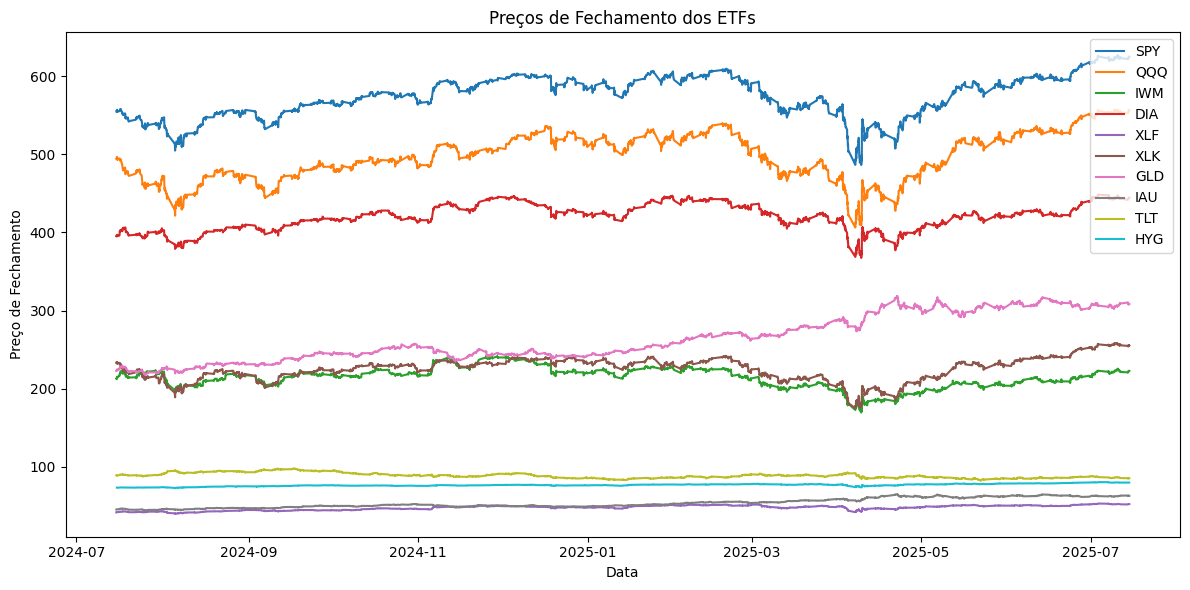

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for symbol, data in etfs_close_data.items():
    plt.plot(data.index, data['Close'], label=symbol)

plt.title("Preços de Fechamento dos ETFs")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# df = crypto_close_data["SOL/USD"]
df = etfs_close_data["GLD"]
df

Open      High       Low     Close     Volume
Timestamp                                                                 
2024-07-15 08:00:00+00:00  223.50  223.5000  222.6300  222.9000      764.0
2024-07-15 09:00:00+00:00  222.83  222.8300  222.8300  222.8300      111.0
2024-07-15 10:00:00+00:00  223.00  223.3500  222.9700  223.3500    12955.0
2024-07-15 11:00:00+00:00  223.32  223.7200  223.3200  223.5400     7455.0
2024-07-15 12:00:00+00:00  223.57  223.8100  222.1000  223.3200    81740.0
...                           ...       ...       ...       ...        ...
2025-07-14 19:00:00+00:00  308.46  308.6000  307.9300  308.0100  1161527.0
2025-07-14 20:00:00+00:00  308.01  308.3100  307.6606  307.7900   135121.0
2025-07-14 21:00:00+00:00  307.52  308.0416  307.5200  307.9000     1249.0
2025-07-14 22:00:00+00:00  307.96  308.1696  307.5800  308.1696     4550.0
2025-07-14 23:00:00+00:00  308.14  308.2700  307.9018  308.2700     2432.0

[3973 rows x 5 columns]

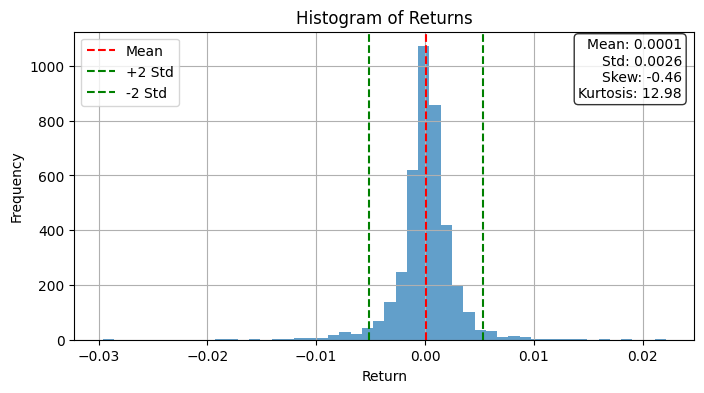

In [56]:
import matplotlib.pyplot as plt

returns = df['Close'].pct_change().dropna()
fig, ax = plt.subplots(figsize=(8, 4))
returns.hist(bins=50, ax=ax, alpha=0.7)

mean = returns.mean()
std = returns.std()
skew = returns.skew()
kurt = returns.kurtosis()

# Adiciona linhas para média e ±2 std
ax.axvline(mean, color='red', linestyle='--', label='Mean')
ax.axvline(mean + 2*std, color='green', linestyle='--', label='+2 Std')
ax.axvline(mean - 2*std, color='green', linestyle='--', label='-2 Std')

stats_text = (
    f"Mean: {mean:.4f}\n"
    f"Std: {std:.4f}\n"
    f"Skew: {skew:.2f}\n"
    f"Kurtosis: {kurt:.2f}"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

ax.set_title("Histogram of Returns")
ax.set_xlabel("Return")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

In [58]:
bt = Backtest(df, ZScoreMeanReversion_StopLoss, cash=100_000, commission=.01, exclusive_orders=True)
results = bt.run()
# results = bt.optimize(
#     window=range(20, 200, 20),
#     threshold=[1.5, 2, 2.5, 3, 3.5, 4],
#     stop_loss_pct=[0.01, 0.03, 0.05],
#     maximize='Sharpe Ratio',
#     # constraint=lambda p: p.window < p.threshold
# )
print(results._strategy)

print(f"Return [%]:           {results['Return [%]']:.2f}")
print(f"Buy & Hold Return [%]: {results['Buy & Hold Return [%]']:.2f}")
print(f"Sharpe Ratio:         {results['Sharpe Ratio']:.2f}")
print(f"# Trades:             {results['_trades'].shape[0]}")
print(f"Win Rate:             {results['Win Rate [%]']:.2f}%")
print(f"Max Drawdown [%]:     {results['Max. Drawdown [%]']:.2f}")
print(f"Avg Trade Duration:   {results['Avg. Trade Duration']}")
print(f"Best Trade [%]:       {results['Best Trade [%]']:.2f}")
print(f"Worst Trade [%]:      {results['Worst Trade [%]']:.2f}")
print("="*60)
bt.plot()

ZScoreMeanReversion_StopLoss
Return [%]:           -15.83
Buy & Hold Return [%]: 35.22
Sharpe Ratio:         -5.63
# Trades:             29
Win Rate:             55.17%
Max Drawdown [%]:     -15.95
Avg Trade Duration:   1 days 17:00:00
Best Trade [%]:       1.76
Worst Trade [%]:      -2.10


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p10953', ...)

In [61]:
bt = Backtest(df, ZScoreMeanReversionImproved, cash=100_000, commission=.01, exclusive_orders=True)
# results = bt.run()
results = bt.optimize(
    window=range(20, 200, 20),
    threshold=[1.5, 2, 2.5, 3, 3.5, 4],
    stop_loss_pct=[0.01, 0.03, 0.05],
    atr_window=[20, 25, 30, 35],
    cooldown_period=[5, 10, 15],
    maximize='Sharpe Ratio',
    # constraint=lambda p: p.short_window < p.long_window
)
print(results._strategy)

print(f"Return [%]:           {results['Return [%]']:.2f}")
print(f"Buy & Hold Return [%]: {results['Buy & Hold Return [%]']:.2f}")
print(f"Sharpe Ratio:         {results['Sharpe Ratio']:.2f}")
print(f"# Trades:             {results['_trades'].shape[0]}")
print(f"Win Rate:             {results['Win Rate [%]']:.2f}%")
print(f"Max Drawdown [%]:     {results['Max. Drawdown [%]']:.2f}")
print(f"Avg Trade Duration:   {results['Avg. Trade Duration']}")
print(f"Best Trade [%]:       {results['Best Trade [%]']:.2f}")
print(f"Worst Trade [%]:      {results['Worst Trade [%]']:.2f}")
print("="*60)
bt.plot()

/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/backtesting/backtesting.py:1606: UserWarning: Searching for best of 1944 configurations.
  output = _optimize_grid()


ZScoreMeanReversionImproved(window=180,threshold=4.0,stop_loss_pct=0.05,atr_window=20,cooldown_period=5)
Return [%]:           -0.08
Buy & Hold Return [%]: 39.40
Sharpe Ratio:         -0.76
# Trades:             1
Win Rate:             0.00%
Max Drawdown [%]:     -0.15
Avg Trade Duration:   13 days 19:00:00
Best Trade [%]:       -1.29
Worst Trade [%]:      -1.29


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p11982', ...)

In [48]:
bt = Backtest(df, MeanReversionIBS, cash=100_000, commission=.01, exclusive_orders=True)
results = bt.run()
# results = bt.optimize(
#     hl_window=range(5, 30, 2),
#     high_window=range(30, 100, 5),
#     ibs_threshold=[0.1, 0.2, 0.3, 0.4],
#     maximize='Sharpe Ratio',
#     constraint=lambda p: p.hl_window < p.high_window
# )
print(results._strategy)


print(f"Return [%]:           {results['Return [%]']:.2f}")
print(f"Buy & Hold Return [%]: {results['Buy & Hold Return [%]']:.2f}")
print(f"Sharpe Ratio:         {results['Sharpe Ratio']:.2f}")
print(f"# Trades:             {results['_trades'].shape[0]}")
print(f"Win Rate:             {results['Win Rate [%]']:.2f}%")
print(f"Max Drawdown [%]:     {results['Max. Drawdown [%]']:.2f}")
print(f"Avg Trade Duration:   {results['Avg. Trade Duration']}")
print(f"Best Trade [%]:       {results['Best Trade [%]']:.2f}")
print(f"Worst Trade [%]:      {results['Worst Trade [%]']:.2f}")
print("="*60)
bt.plot()

/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/backtesting/backtesting.py:1606: UserWarning: Searching for best of 728 configurations.
  output = _optimize_grid()


MeanReversionIBS(hl_window=13,high_window=30,ibs_threshold=0.1)
Return [%]:           -27.37
Buy & Hold Return [%]: 48.58
Sharpe Ratio:         -14.77
# Trades:             234
Win Rate:             58.55%
Max Drawdown [%]:     -27.37
Avg Trade Duration:   0 days 13:00:00
Best Trade [%]:       12.16
Worst Trade [%]:      -5.29


/Users/guilistocco/Trabalho_Final/trading_strategy/trading_env/lib/python3.10/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p11742', ...)